In [1]:
import warnings
import pandas as pd
import arviz as az

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
#from libs.model import HGPforecaster
from libs.metrics import calculate_metrics, metrics_to_table, metrics_to_latex
from libs.pre_processing import generate_groups_data_flat
from libs.visual_analysis import visualize_fit, visualize_predict, traceplot
from libs.model import HGPforecaster
import numpy as np
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

import theano
theano.config.compute_test_value='raise'

In [2]:
prison = pd.read_csv('../data/prisonLF.csv', sep=",")
prison = prison.drop('Unnamed: 0', axis =1)
prison['t'] = prison['t'].astype('datetime64[ns]')

In [3]:
prison_pivot = prison.pivot(index='t',columns=['state', 'gender', 'legal'], values='count')

In [4]:
groups_input = {
    'state': [0],
    'gender': [1],
    'legal': [2]
}

In [5]:
groups = generate_groups_data_flat(y = prison_pivot, 
                               groups_input = groups_input, 
                               seasonality=4, 
                               h=8)

Number of groups: 3
	state: 8
	gender: 2
	legal: 2
Total number of series: 32
Number of points per series for train: 40
Total number of points: 48
Seasonality: 4
Forecast horizon: 8


# Testing with minibatch

In [6]:
m = HGPforecaster(groups_data=groups,
                  n_iterations=100000,
                  log_lin_mean=True)#,
                  #minibatch=[30,20])

In [7]:
m.prior_predictive_checks()

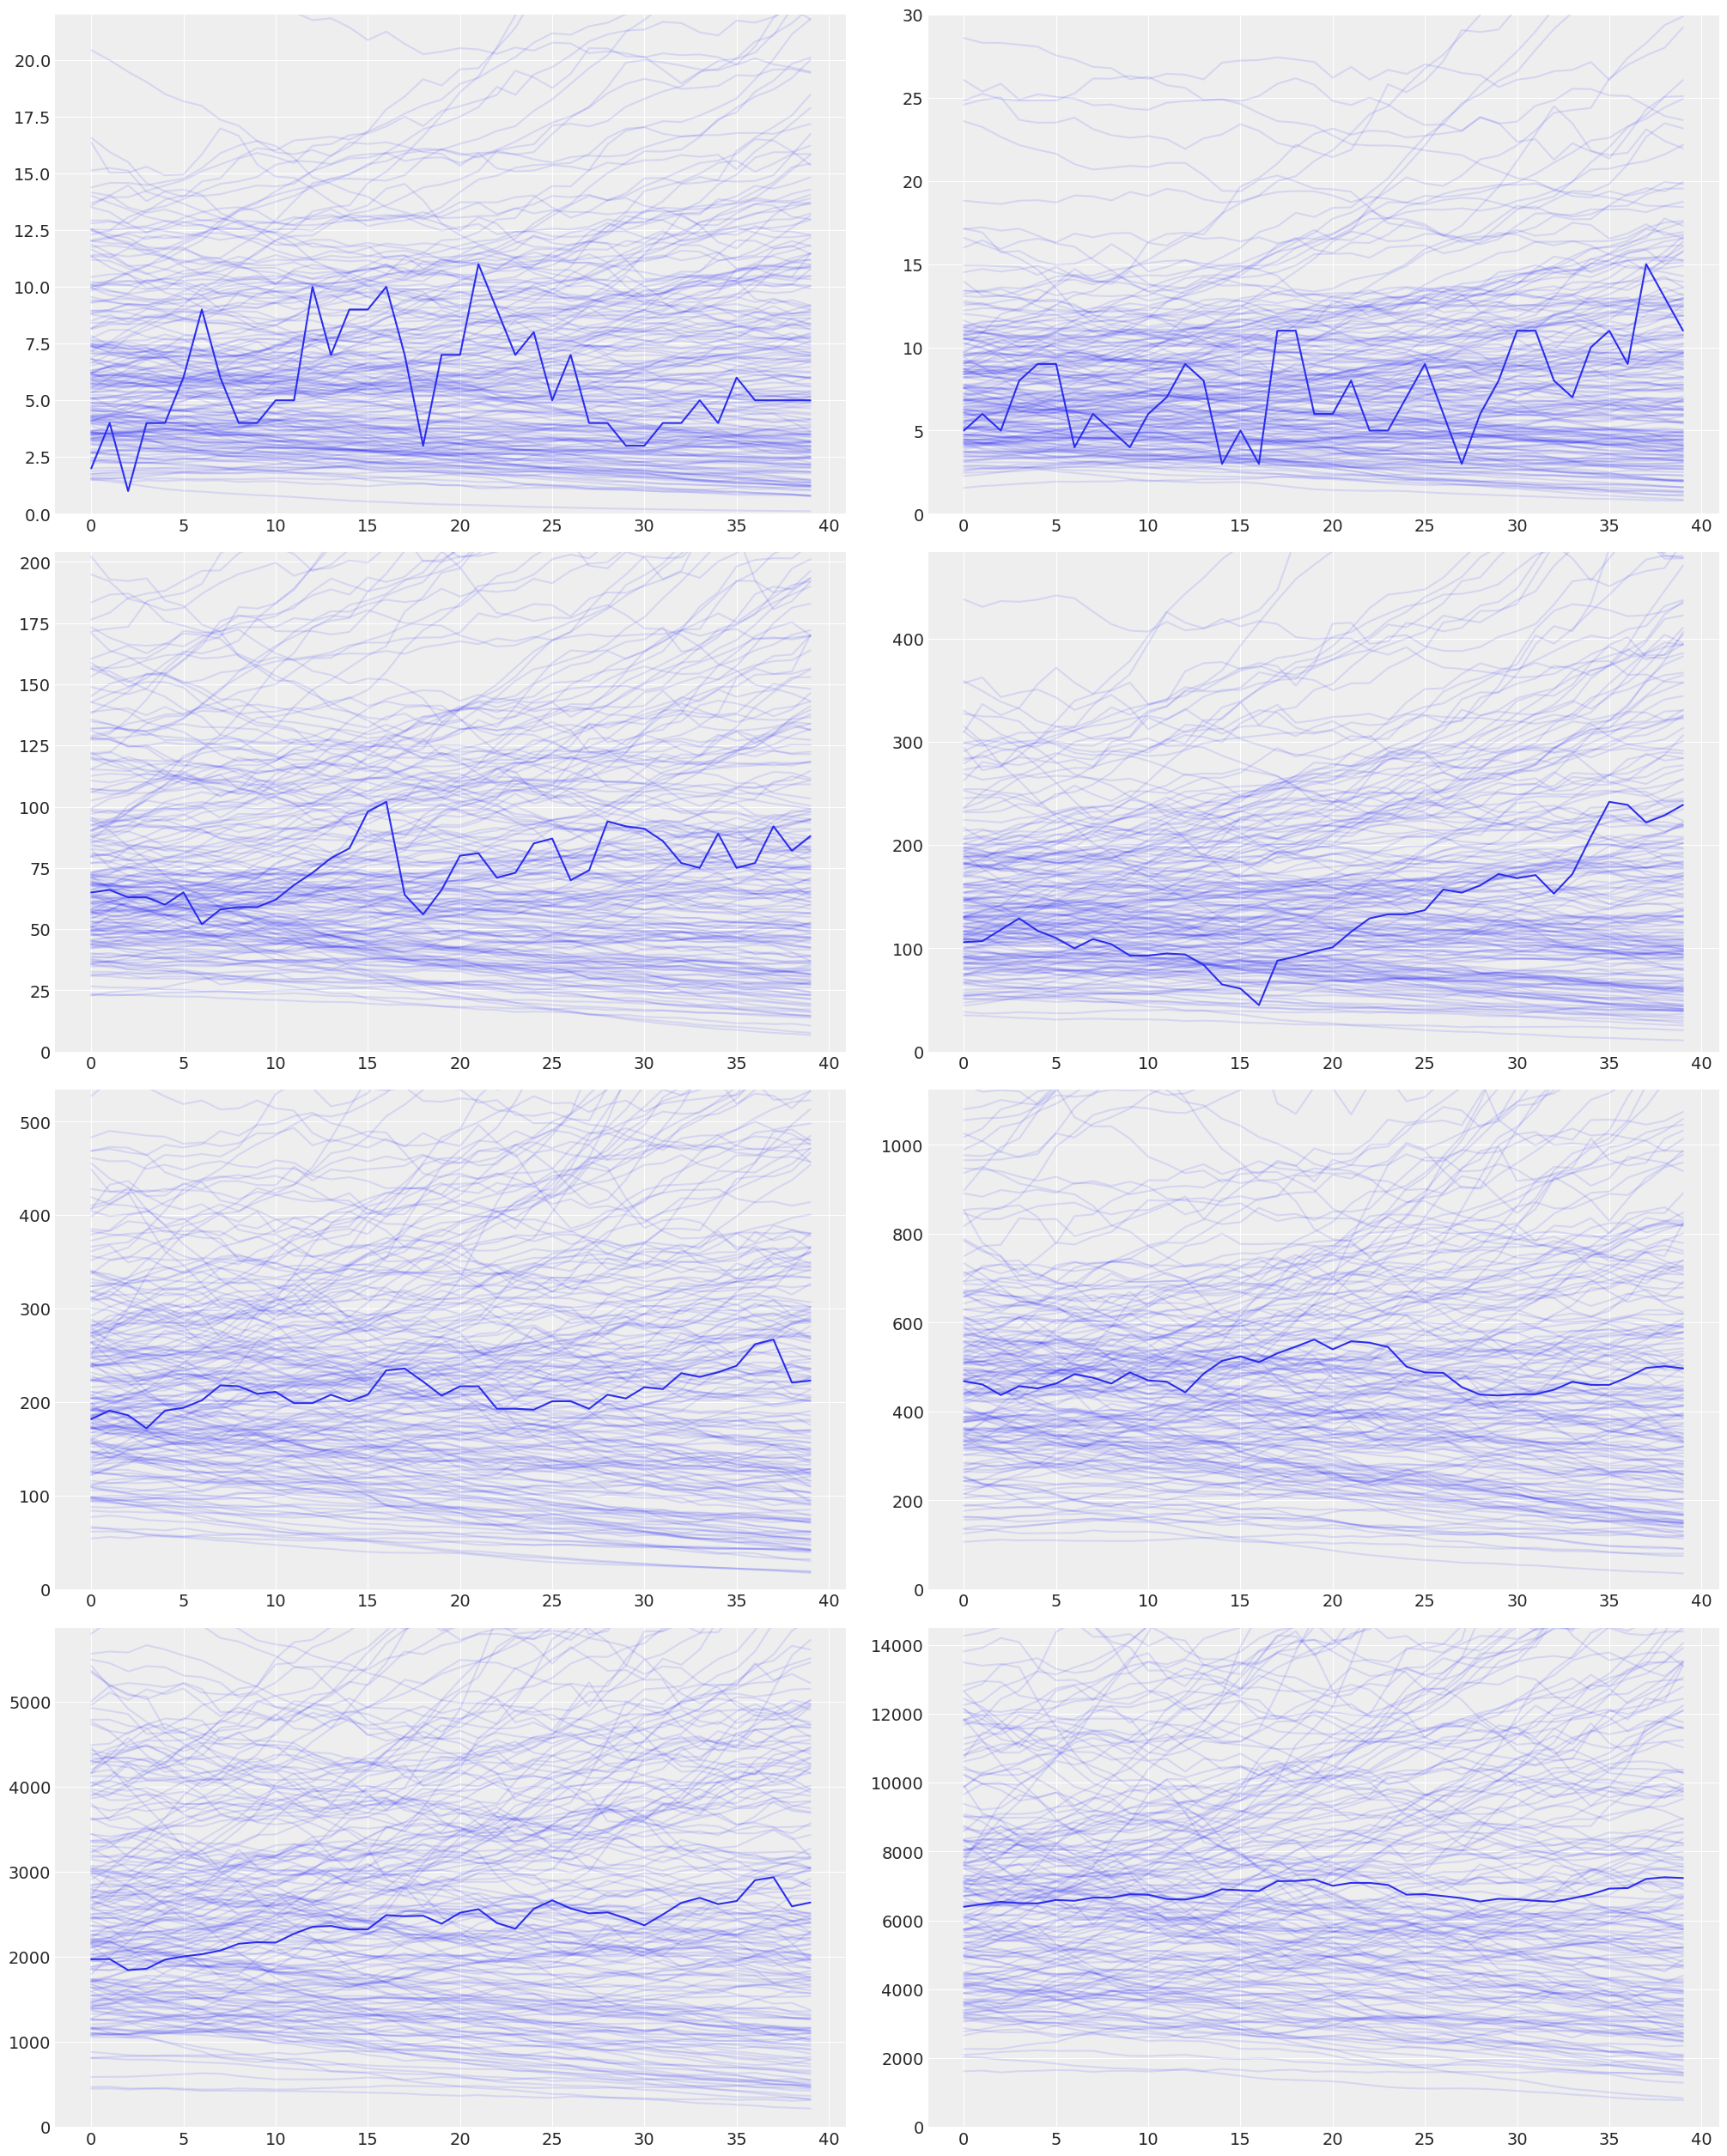

In [8]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(4, 2, figsize=(20, 25))
ax = ax.ravel()

for i in range(8):
    ax[i].plot(m.prior_checks['f_'][:,:,i].T, color='b', alpha=0.1)
    ax[i].plot(groups['train']['data'][:,i])
    ax[i].set_ylim(0, max(groups['train']['data'][:,i])*2);

In [9]:
m.fit_vi()

Fitting model...


Finished [100%]: Average Loss = 36,490


Sampling...


In [10]:
m.predict()

Sampling...


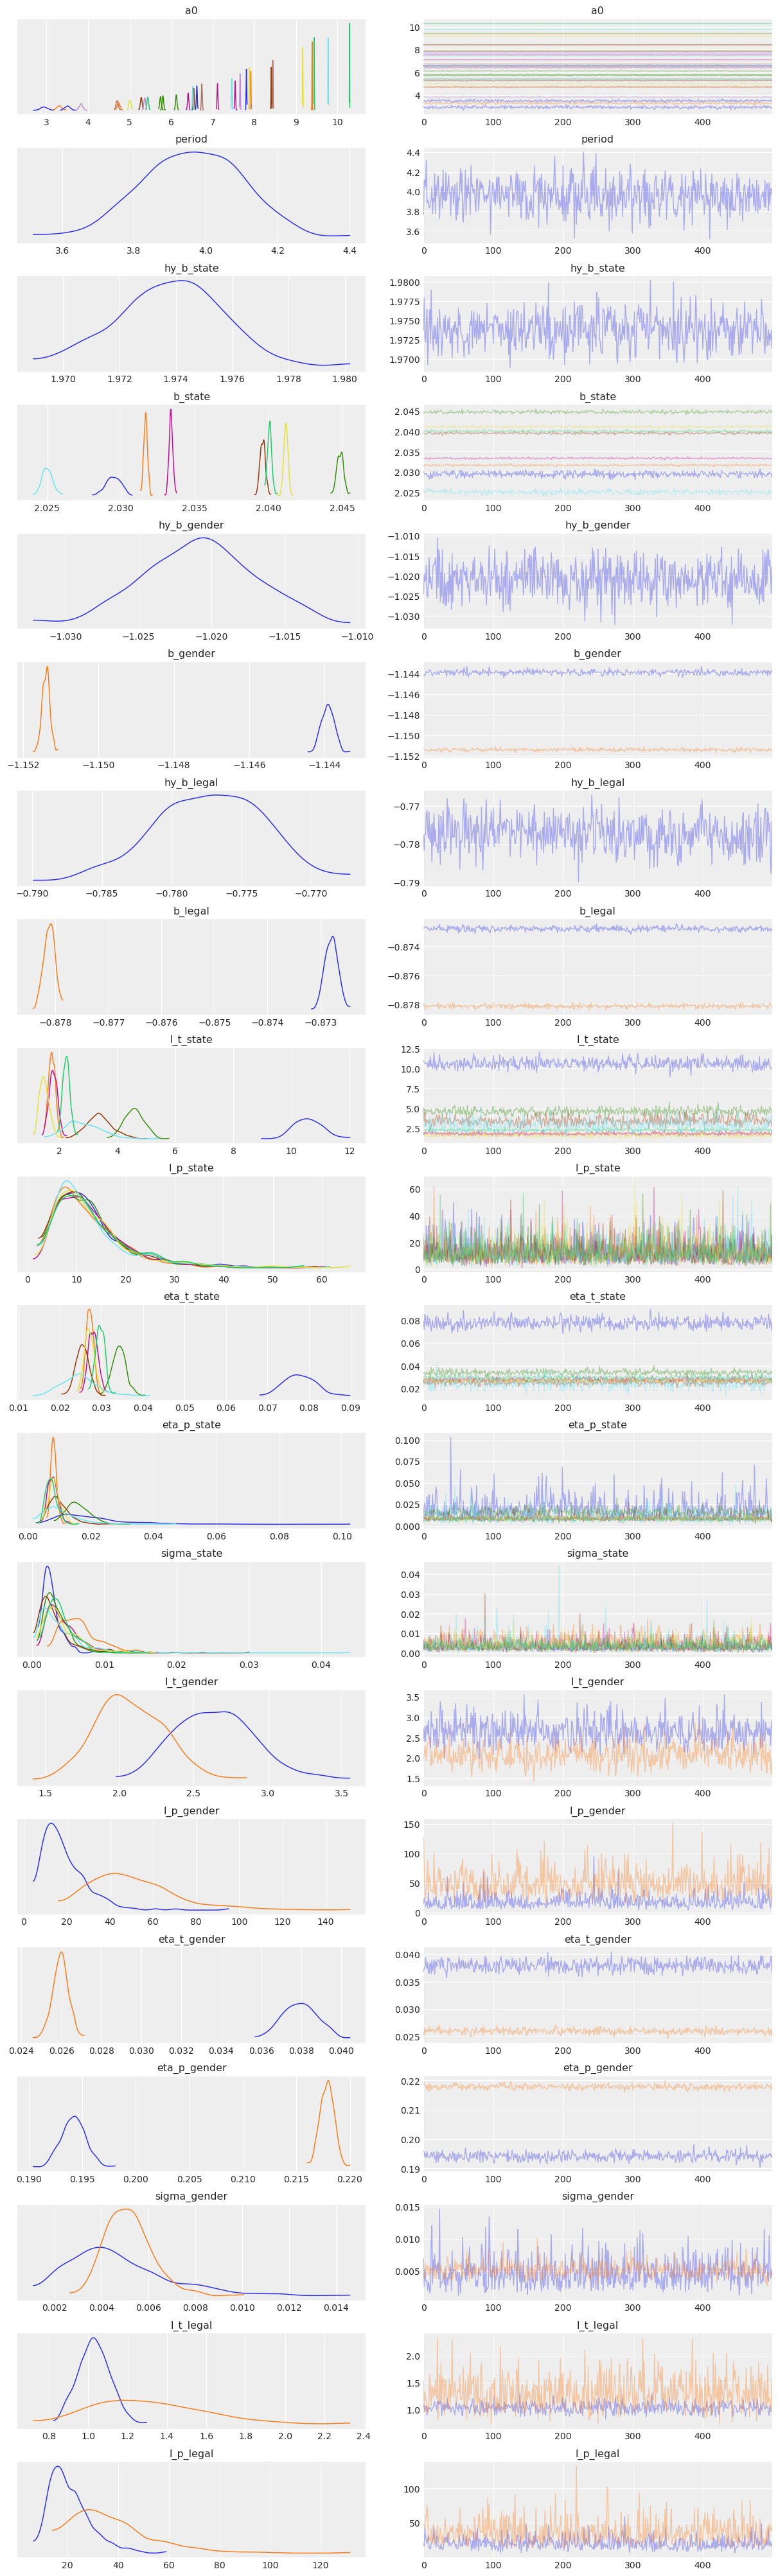

In [11]:
traceplot(m.trace_vi_samples);

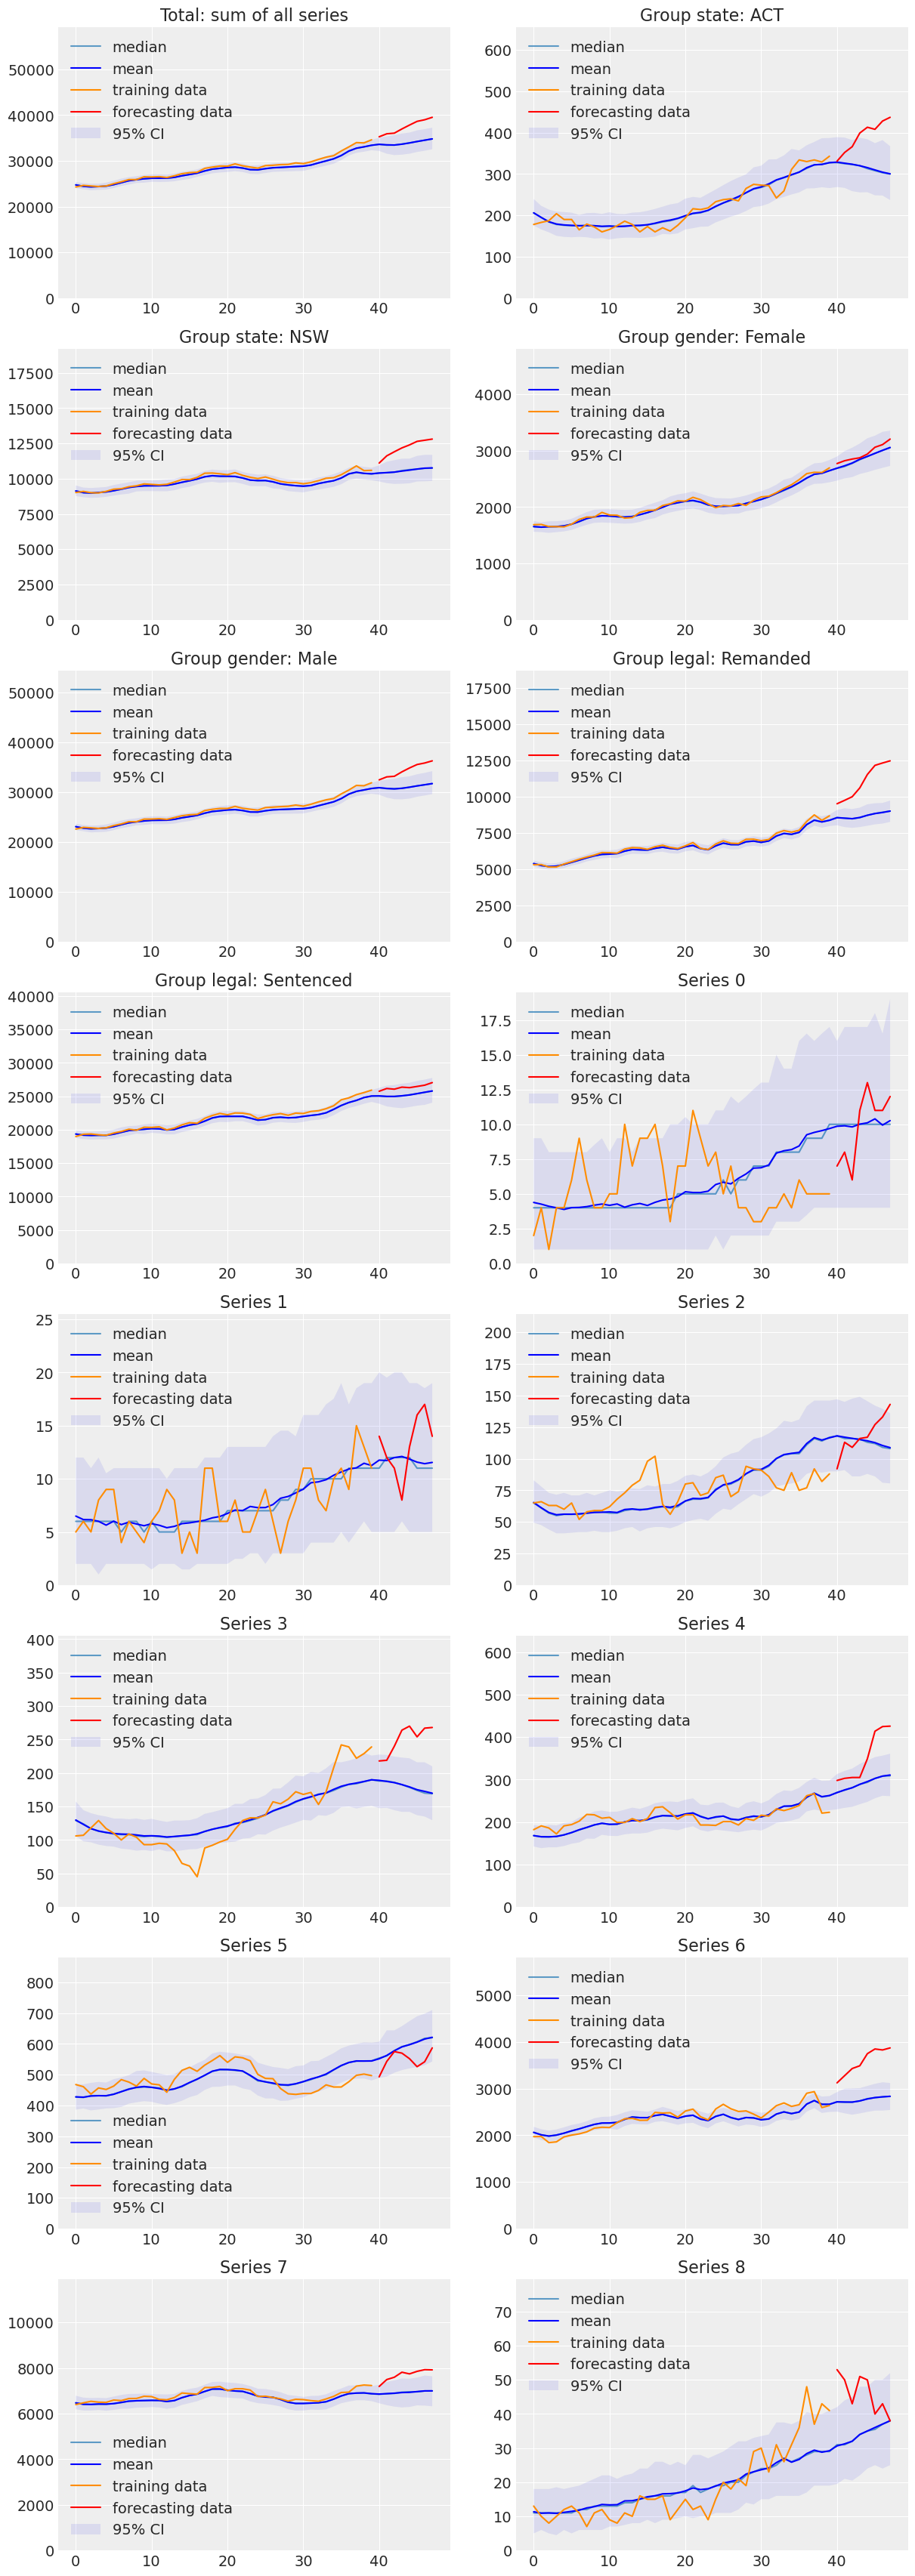

In [12]:
visualize_predict(groups, m.pred_samples_predict['y_pred_new'], 10)

In [13]:
results = calculate_metrics(m.pred_samples_predict['y_pred_new'], groups)
metrics_to_table(groups, results)